In [6]:
# Necessary imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.text import Text
from string import ascii_uppercase
from IPython.display import display

In [7]:
# Chromosome stuff
used_chromosomes = np.concatenate((np.arange(1, 19), np.arange(20, 23)))

chromosome_lengths_arr = [249250621,243199373,198022430,191154276,180915260,171115067,159138663,146364022,141213431,135534747,135006516,133851895,115169878,107349540,102531392,90354753,81195210,78077248,59128983,63025520,48129895,51304566]
binsize = 500000
chromosome_lengths_arr = np.ceil(np.array(chromosome_lengths_arr) / binsize) * binsize
chromosome_length_map = dict(zip(np.arange(1, 23), chromosome_lengths_arr))

used_chromosome_lengths = [chromosome_length_map[c] for c in used_chromosomes]
total_used_chromosome_length = sum(used_chromosome_lengths)
used_chromosome_starts  = np.cumsum(np.concatenate(([0], used_chromosome_lengths)))
chromosome_start_map = dict(zip(used_chromosomes, used_chromosome_starts))


In [8]:
colors = {
    "loss": {True: "Red",
            False: "LightPink"
            },
    "gain": {True: "Blue",
             False: "LightBlue"
            }
}


# Functions
def get_minwidth(axes):
    # Get the minimum displayable width for the axes - one pixel
    
    t = axes.transAxes.transform([(0,0), (1,1)])
    minwidth = total_used_chromosome_length / (t[1,0] - t[0,0])
    return minwidth


def render_aberrations(axes, cases, labels, boxheight=0.8, n_types=1):
    # Data should be a list of cases, where each case is a list of tuples [chromosome, start, end, gain/loss, amplified]
    
    # Let the minimum block be 2 pixels
    minwidth = 5 * get_minwidth(axes)
    
    # Generate effect patches
    patches = []
    for i, case in enumerate(cases):
        base = i + (1-boxheight)/2
        
        for chromosome, inc_start, inc_end, gainorloss, amplified in case:
            color = colors[gainorloss][amplified]
            if chromosome not in used_chromosomes:
                # ignoring unused chromosome
                continue
            start = chromosome_start_map[chromosome] + inc_start
            end   = chromosome_start_map[chromosome] + inc_end

            if end-start < minwidth:
                # Adjust aberrations that wouldn't otherwise be displayed to show
                mid = (start+end)/2
                start = mid-minwidth/2
                end = mid+minwidth/2
            
            patches.append(Rectangle(xy=(start, base), width=(end-start), height=boxheight, facecolor=color, antialiased=False))
            
    # Render patches and set plot limits
    ax.add_collection(PatchCollection(patches, match_original=True, antialiased=False))
    ax.set_xlim((0, total_used_chromosome_length))
    ax.set_ylim((0, len(cases)))

    ax.set_yticks(np.arange(0.5, len(cases)), minor=True)
    ax.set_yticklabels(labels, minor=True)
    
    ax.set_yticks(np.arange(0, len(cases)+1, n_types))
    ax.set_yticklabels([])
    ax.tick_params(axis='y', which='major', length=0)
    
    ax.grid(axis='y', linestyle=':')

    # Add ticks to chromosome boundaries and add label inbetween ticks
    ax.set_xticks(used_chromosome_starts)
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which='major', length=15)

    ax.set_xticks((used_chromosome_starts[1:] + used_chromosome_starts[:-1]) / 2, minor=True)
    ax.set_xticklabels(used_chromosomes, minor=True)
    ax.tick_params(axis='x', which='minor', length=0)

    ax.grid(axis='x', linestyle=':')

In [9]:
def group_data(data, analysis_types):
    by_participant = data.groupby("participant")

    labels = []
    all_data = []

    for participant, data in by_participant:
        for suffix, analysis in analysis_types:
            analysis_data = data.loc[data["analysis"] == analysis, ["chromosome", "start", "end", "gain/loss", "amplified"]]
            all_data.append(analysis_data.to_numpy())
            labels.append(participant+suffix)

    return all_data, labels

In [10]:
def group_and_add_annotations(ax, annotation_data):
    annotations = [
        (ann.Name,
         chromosome_start_map[ann.Chromosome]+ann.Start,
         "black" if ann.Important == "y" else "gray")
        for _, ann in annotation_data.iterrows()]
    
    add_annotations(ax, annotations)

def add_annotations(ax, annotation_tuples):
    ymin, ymax = ax.get_ylim()
    
    for label, x, color in annotation_tuples:
        line = Line2D([x], [ymin, ymax], linewidth=1, color=color, linestyle='--')

        ax.add_line(line)
        ax.annotate(label, xy=(x, ymax), xytext=(x, ymax+0.5), rotation="vertical", ha="center")

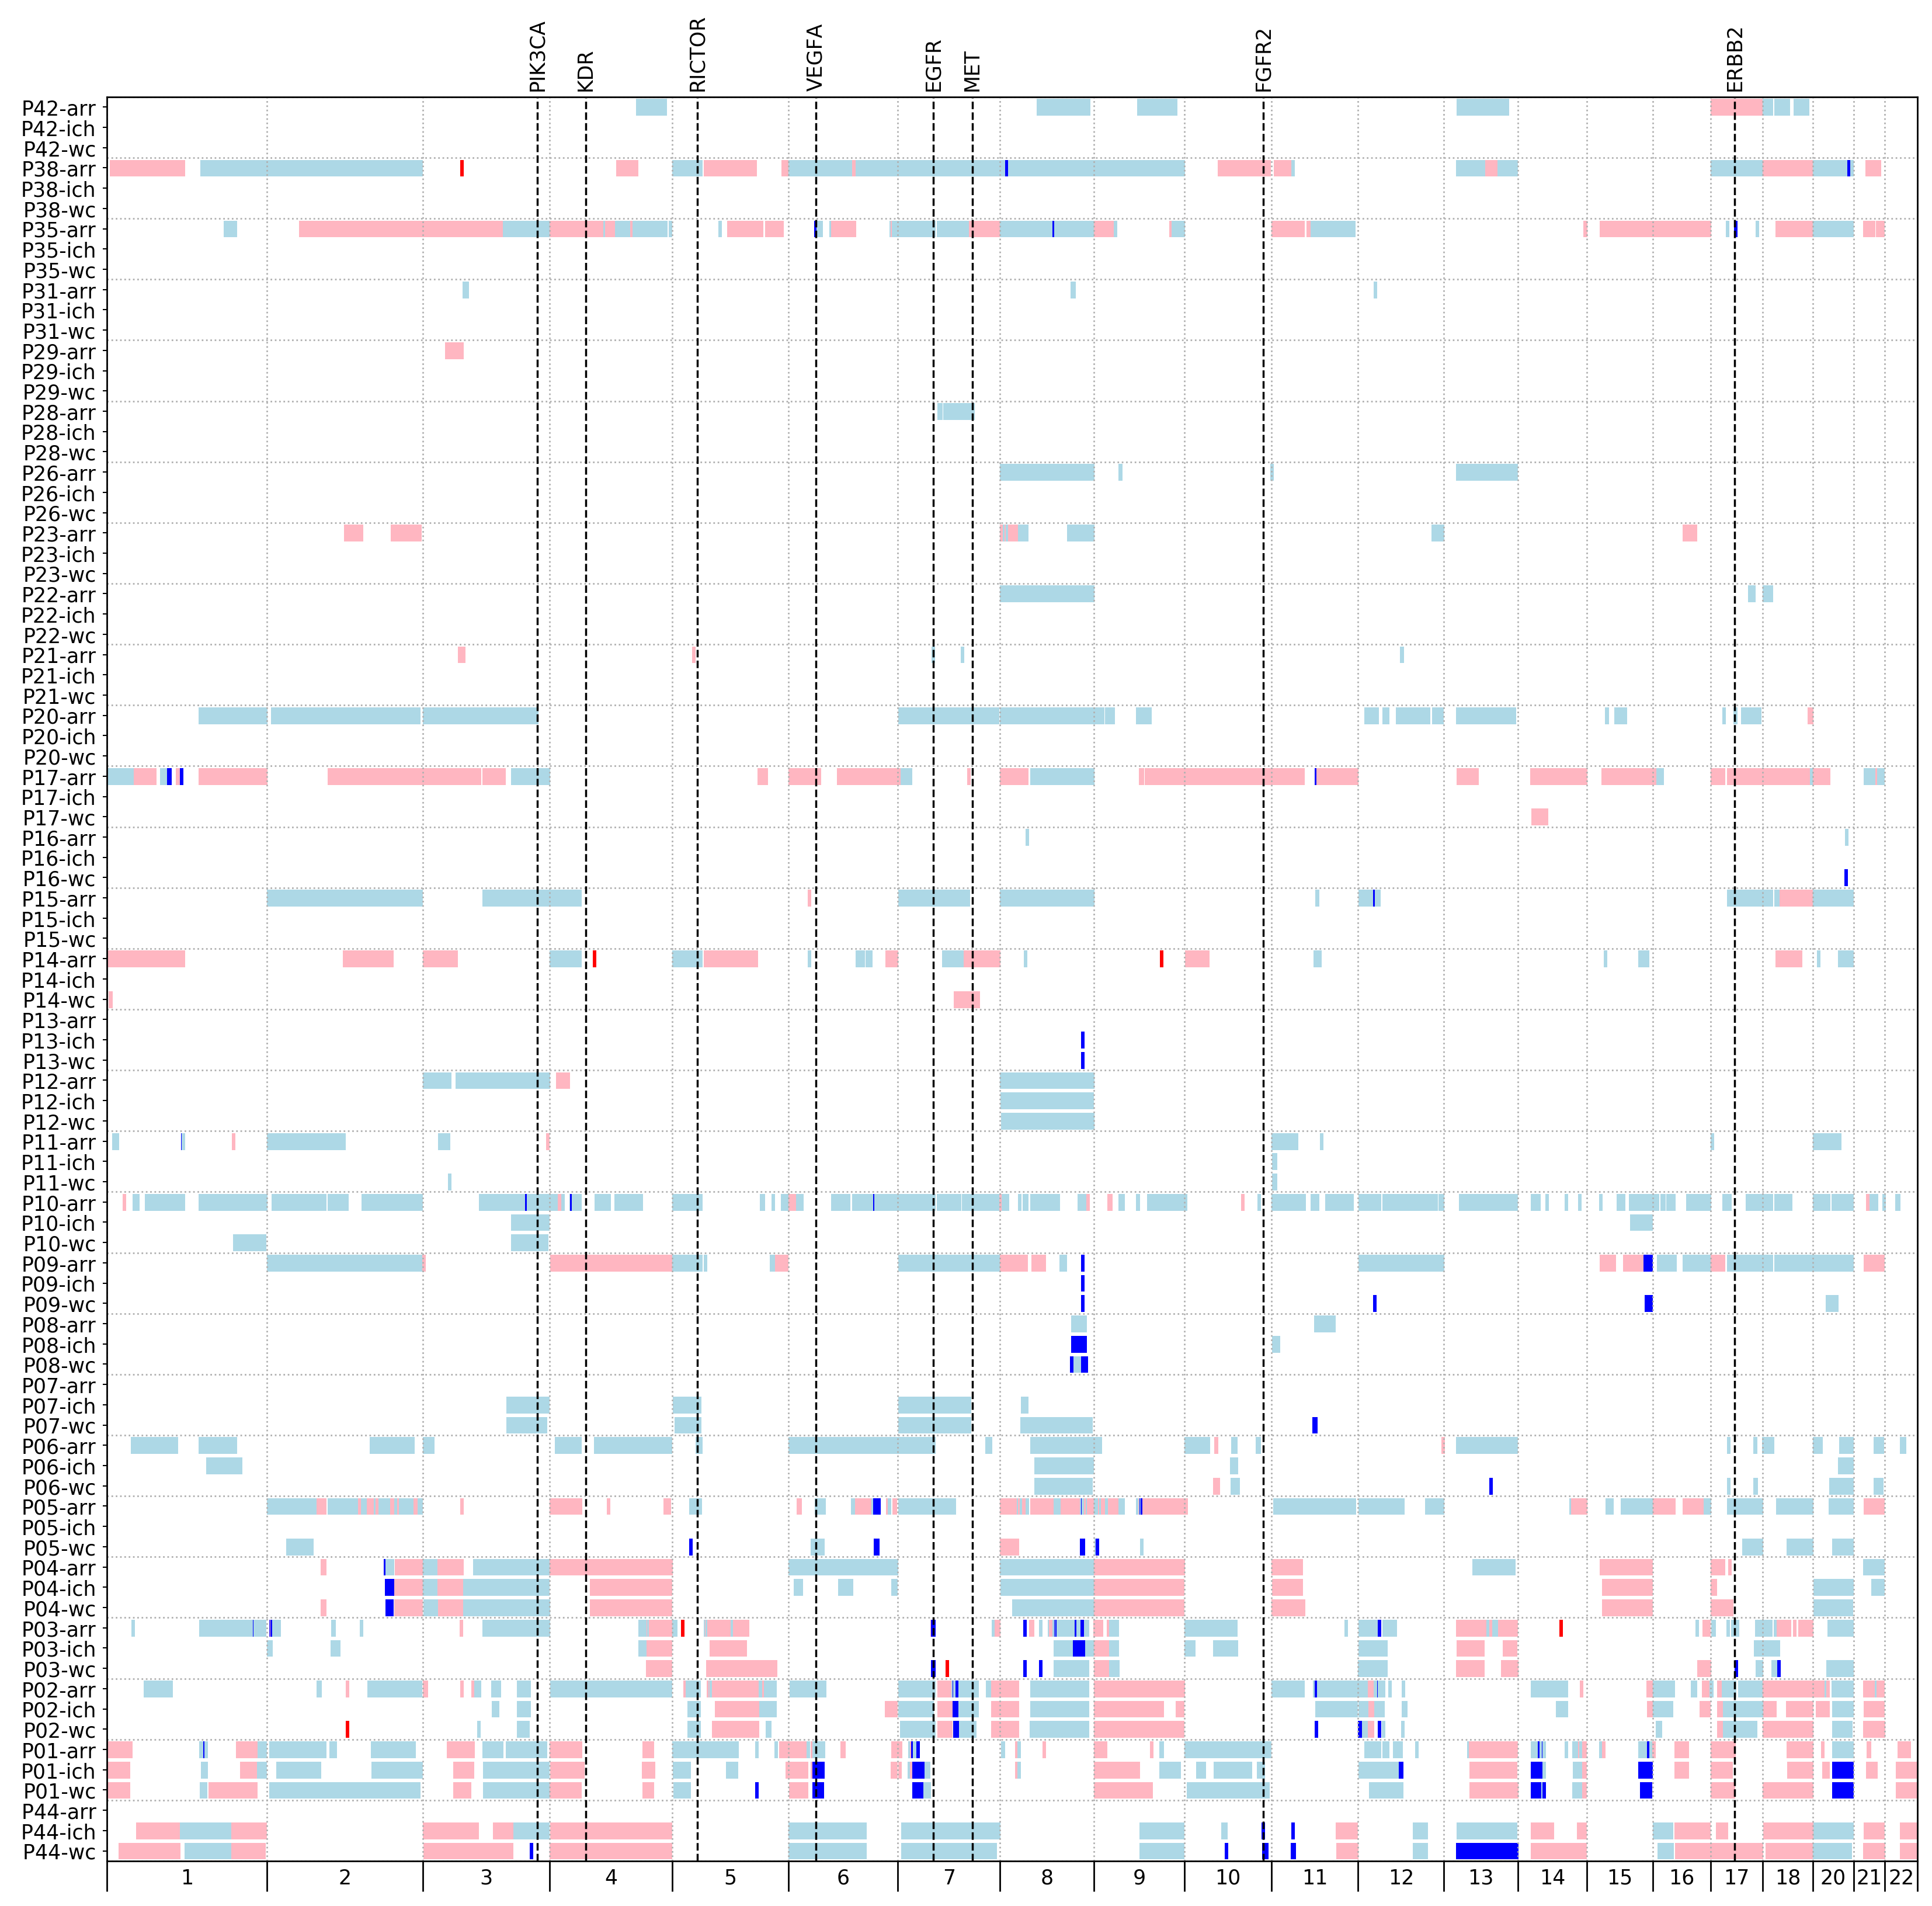

In [17]:
# Figure setup
fig = plt.figure(figsize=(16,16), dpi=250)
ax = fig.add_subplot(111)
plt.rcParams["font.family"] = "Bitstream Vera Sans"

"""
# Read data and render aberrations
inp_exc = pd.read_excel("Input_plasma_191007.xlsx", sheet_name=1)

data = pd.DataFrame({'analysis': inp_exc['WC/ichor/array'],
                     'participant': inp_exc['Participant'],
                     'chromosome': inp_exc['chromosome'],
                     'start': inp_exc['start'],
                     'end': inp_exc['end'],
                     'gain/loss': inp_exc['gain/loss'],
                     'amplified': inp_exc['effect'] > 5})

all_data, labels = group_data(data, [("-wc", "WC"), ("-ich", "ichor")])
render_aberrations(ax, all_data, labels, n_types=2)

# Read data and render aberrations
inp_exc = pd.read_excel("KW_Ollantafiguren_input.xlsx", sheet_name=1)

data = pd.DataFrame({'analysis': inp_exc['WC/ichor/array'],
                     'participant': inp_exc['case'],
                     'chromosome': inp_exc['chromosome'],
                     'start': inp_exc['start'],
                     'end': inp_exc['end'],
                     'gain/loss': inp_exc['gain/loss'],
                     'amplified': False})

all_data, labels = group_data(data, [("", "array")])
render_aberrations(ax, all_data, labels, n_types=1)
"""

# Read data and render aberrations
inp_exc = pd.read_excel("Input_ollantafigur_191123.xlsx", sheet_name=0)

data = pd.DataFrame({'analysis': inp_exc['WC/ichor/array'],
                     'participant': inp_exc['Patient'],
                     'chromosome': inp_exc['Chrom'],
                     'start': inp_exc['Start'],
                     'end': inp_exc['Stop'],
                     'gain/loss': inp_exc['gain/loss'],
                     'amplified': False})

wcorichor = (data["analysis"] == "WC") | (data["analysis"] == "ichor")
data.loc[(wcorichor) & (inp_exc["Effect/TFx"] > 1.5), "amplified"] = True
data.loc[(wcorichor) & (inp_exc["Effect/TFx"].isna()) & (inp_exc["effect"] > 4.5), "amplified"] = True
data.loc[(data["analysis"] == "array") & (inp_exc["MLR"] > 1.32), "amplified"] = True

all_data, labels = group_data(data, [("-wc", "WC"), ("-ich", "ichor"), ("-arr", "array")])
render_aberrations(ax, all_data, labels, n_types=3)

# Read region data and add annotations
reg_exc = pd.read_excel("Regioner-new.xlsx", sheet_name=0)

group_and_add_annotations(ax, reg_exc)
